# Practice4. Keras

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [3]:
import sys
from tensorflow.python.client import device_lib
print (device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1919159623963468399
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 8706762343
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 15080045270619669265
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:41:00.0, compute capability: 6.1"
]


In [4]:
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import pickle
import time

# set default plot options
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## 1. Set up input preprocessing

In [5]:
from utils import get_CIFAR10_data

In [6]:
X_tr, Y_tr, X_te, Y_te, mean_img = get_CIFAR10_data()
print ('Train data shape : %s,  Train labels shape : %s' % (X_tr.shape, Y_tr.shape))
print ('Test data shape : %s,  Test labels shape : %s' % (X_te.shape, Y_te.shape))

Train data shape : (10000, 3072),  Train labels shape : (10000,)
Test data shape : (1000, 3072),  Test labels shape : (1000,)


### Input data를 CNN Model의 Input에 맞는 3차원 형태의 데이터로 만들기

In [7]:
print ('X_tr : ', X_tr.shape)
print ('X_te : ', X_te.shape)

X_tr :  (10000, 3072)
X_te :  (1000, 3072)


In [8]:
X_tr_input = X_tr.reshape(-1,32,32,3)
X_te_input = X_te.reshape(-1,32,32,3)

In [9]:
print ('X_tr : ', X_tr_input.shape)
print ('X_te : ', X_te_input.shape)

X_tr :  (10000, 32, 32, 3)
X_te :  (1000, 32, 32, 3)


### Label data를 one-hot vector로 만들기

In [10]:
print ('Y_tr : ', Y_tr[0:10])
print ('Y_te : ', Y_te[0:10])

Y_tr :  [6 9 9 4 1 1 2 7 8 3]
Y_te :  [3 8 8 0 6 6 1 6 3 1]


In [11]:
from keras.utils import to_categorical
Y_te_onehot = to_categorical(Y_te, num_classes=10)
Y_tr_onehot = to_categorical(Y_tr, num_classes=10)

Using TensorFlow backend.


In [12]:
print ('Y_tr_onehot : \n', Y_tr_onehot[0:10])
print ('Y_te_onehot : \n', Y_te_onehot[0:10])
print ('Y_tr_onehot.shape : \n', Y_tr_onehot.shape)
print ('Y_te_onehot.shape : \n', Y_te_onehot.shape)

Y_tr_onehot : 
 [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
Y_te_onehot : 
 [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
Y_tr_onehot.shape : 
 (10000, 10)
Y_te_onehot.shape : 
 (1000, 10)


### Keras 모델 빌드하기
#### 모델을 build 할 때 필요한 데이터 정보 가져오기

In [13]:
input_shape = X_tr_input.shape[1:]
output_shape = Y_te_onehot.shape[1]

print ('input_shape : ', input_shape )
print ('output_shape : ', output_shape )

input_shape :  (32, 32, 3)
output_shape :  10


#### Keras 모델 설계

In [14]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Add, Input, Average
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import plot_model

input_layer = Input(shape=input_shape)
        
layer = input_layer

layer = Conv2D(32, (3, 3), kernel_initializer='RandomNormal', padding='same')(layer)
layer = Activation('relu')(layer)
layer = MaxPooling2D((2,2))(layer)

layer = Conv2D(64, (3, 3), kernel_initializer='RandomNormal', padding='same')(layer)
layer = Activation('relu')(layer)
layer = MaxPooling2D((2,2))(layer)

layer = Conv2D(128, (3, 3), kernel_initializer='RandomNormal', padding='same')(layer)
layer = Activation('relu')(layer)
layer = MaxPooling2D((2,2))(layer)

layer = Flatten()(layer)
layer = Dense(256, kernel_initializer='RandomNormal')(layer)
layer = Dropout(0.5)(layer)
layer = Activation('relu')(layer)
layer = Dense(256, kernel_initializer='RandomNormal')(layer)
layer = Dropout(0.5)(layer)
layer = Activation('relu')(layer)
layer = Dense(output_shape, kernel_initializer='RandomNormal', activation='softmax')(layer)

output_layer = layer
model = Model(inputs=[input_layer], outputs=[output_layer])

#### Optimizer  및 Loss function 선택 후 Model 컴파일

In [15]:
from keras.optimizers import SGD
sgd=SGD(lr=0.01, momentum=0.001, decay=0.0001, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

#### 컴파일된 모델 정보 출력 1

In [16]:
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
__________

#### 컴파일된 모델 정보 출력 2

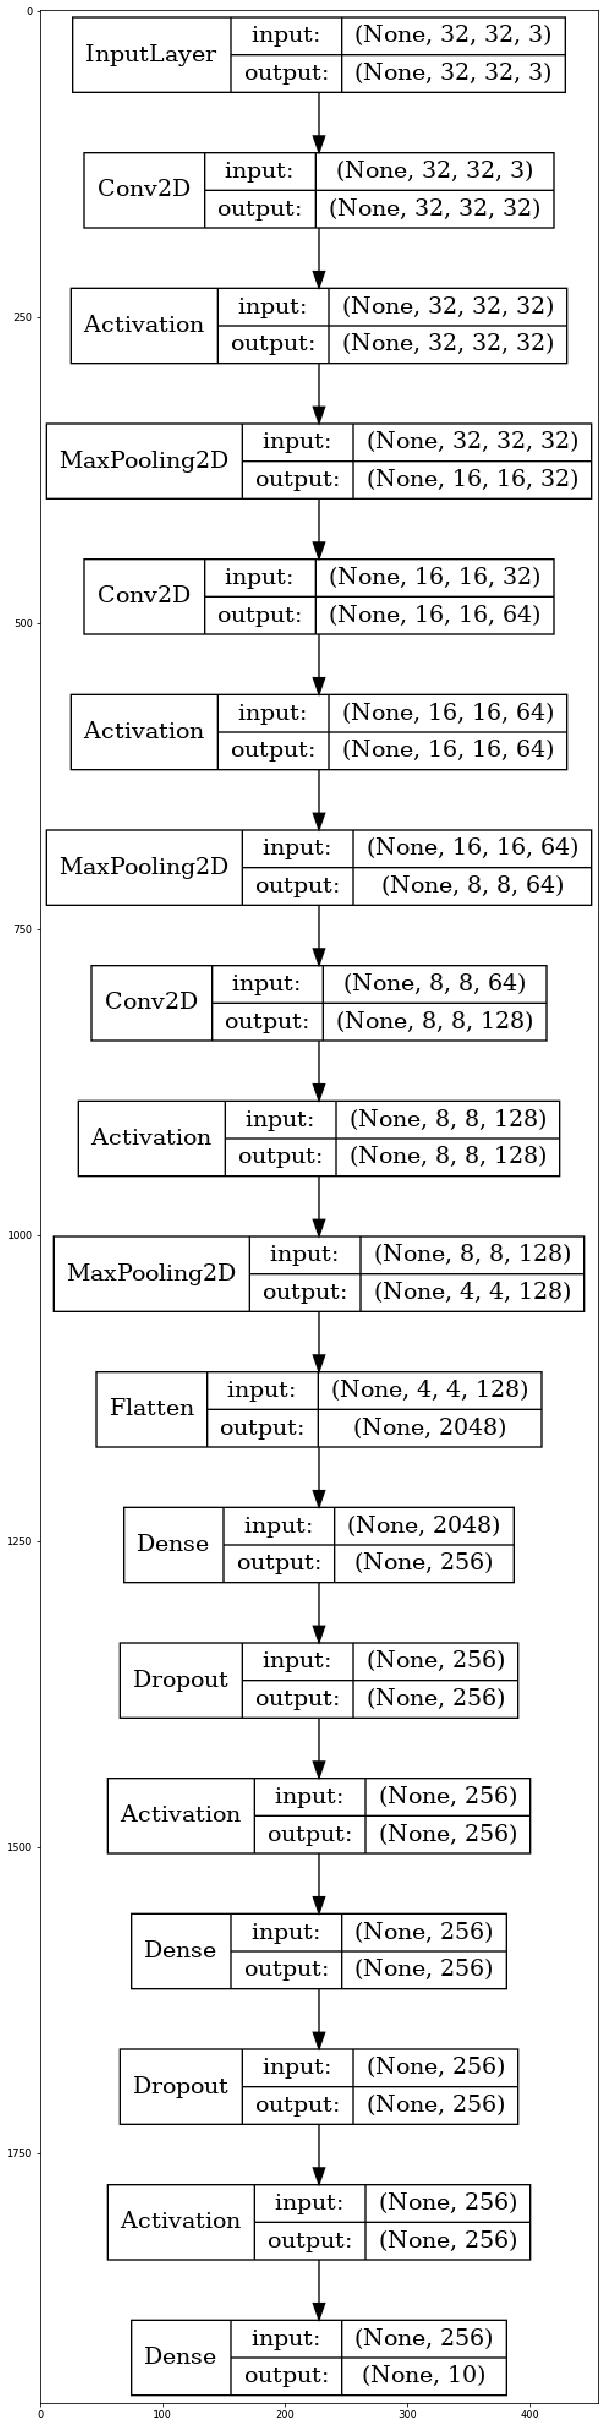

In [17]:
import matplotlib.image as mpimg
plot_model(model,'model_image.png', show_layer_names=False, show_shapes=True)
model_img=mpimg.imread('model_image.png')
plt.figure(figsize=[10,50])
plt.imshow(model_img)

#### Training model

In [18]:
history = model.fit(X_tr_input, Y_tr_onehot,validation_data=[X_te_input, Y_te_onehot], epochs=50, batch_size=128, verbose=1)
# list all data in history

Train on 10000 samples, validate on 1000 samples
Epoch 1/50
10000/10000 [==============================] - 11s 1ms/step - loss: 2.3042 - acc: 0.1050 - val_loss: 2.2988 - val_acc: 0.1480
Epoch 2/50
10000/10000 [==============================] - 3s 286us/step - loss: 2.3008 - acc: 0.1175 - val_loss: 2.2952 - val_acc: 0.1720
Epoch 3/50
10000/10000 [==============================] - 3s 305us/step - loss: 2.2982 - acc: 0.1219 - val_loss: 2.2914 - val_acc: 0.1850
Epoch 4/50
10000/10000 [==============================] - 3s 285us/step - loss: 2.2940 - acc: 0.1325 - val_loss: 2.2862 - val_acc: 0.2130
Epoch 5/50
10000/10000 [==============================] - 3s 301us/step - loss: 2.2880 - acc: 0.1473 - val_loss: 2.2783 - val_acc: 0.2200
Epoch 6/50
10000/10000 [==============================] - 3s 302us/step - loss: 2.2803 - acc: 0.1543 - val_loss: 2.2663 - val_acc: 0.2250
Epoch 7/50
10000/10000 [==============================] - 3s 261us/step - loss: 2.2668 - acc: 0.1717 - val_loss: 2.2470 - va

#### Graph를 이용하여 Training 결과 확인하기

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


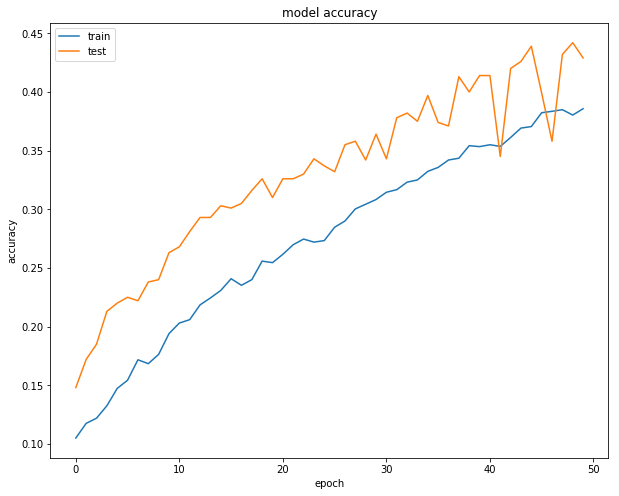

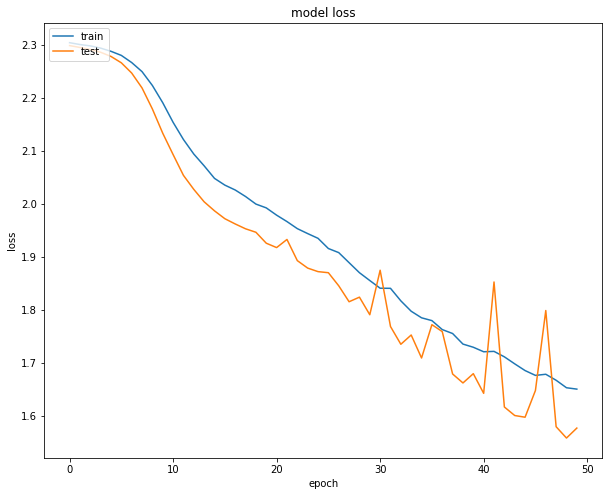

In [19]:
print(history.history.keys())

plt.figure(figsize=[10,8])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(figsize=[10,8])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
print ('best accuracy : ', max(history.history['val_acc']))

best accuracy :  0.4419999995231628


### 참고자료

#### 1. Keras documentation : https://keras.io
#### 2. Keras FAQ: Frequently Asked Keras Questions : https://keras.io/getting-started/faq/
#### 3. Training 한 Weight는 어떻게 저장하나요? : https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model
#### 4. Pre-trained modeld은 어떻게 쓰나요? : https://keras.io/getting-started/faq/#how-can-i-use-pre-trained-models-in-keras
#### 5 Model을 Training 하면서 Checkpoint는 어떻게 설정하나요? : https://machinelearningmastery.com/check-point-deep-learning-models-keras/
#### 6. 각 Epoch의 시작과 끝, Training의 시작과 끝에 custom function을 실행 시킬 수 있나요? : https://keunwoochoi.wordpress.com/2016/07/16/keras-callbacks/
#### 8. Data preprocessing을 위한 class가 있나요? : https://keras.io/preprocessing/image/
#### 9. Custom layer를 생성 할 수 있나요? : https://keras.io/layers/writing-your-own-keras-layers/
#### 10. Residual network는 어떻게 설계하나요? : https://ctmakro.github.io/site/on_learning/resnet_keras.html

### 과제 : 요구조건에 맞는 Model을 생성하고 결과 확인하기

#### 요구조건
1. **Adam optimizer**를 사용하고 내부 parameter는 **default**를 그대로 사용할 것
2. Convolutional layer, Dense layer의 **kernel_regularizer를 0.00001**로 설정할 것
3. Convolutional layer, Dense layer의 **kernel_initializer를 'he_uniform'**으로 설정할 것
3. 모든 Convolutional layer의 **Filter_size를 (3,3)**으로 설정할 것, Padding을 사용할 것
4. Output Layer의 Softmax를 제외한 **Activation function은 'LeakyReLU'**를 사용할 것`
5. Pooling layer는 **MaxPooling(size = (2,2))**를 이용할 것
6. **BatchNormalization Layer**를 사용하고 내부 parameter는 **default**를 그대로 사용할 것
7. Loss function(categorical_crossentropy), metric(Accuracy)는 그대로 유지할 것
8. Mini batch size = 128, Epochs=50으로 진행할 것
9. ****위의 요구조건을 만족시키면서 아래의 그림과 동일한 Layer를 설계하여 Training 및 Test 할 것**** (위 참고자료 및 구글링을 적극 활용할 것)
* 디렉토리 내에 위치한 practice_model1.png, pratice_model2.png 그림을 참고할 것

In [21]:
####################################################################################
#################### 모델 설계에 필요한 Layer를 Import 하세요 #############################

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Add, Input, Average
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import plot_model
from keras.regularizers import l2
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
import keras
#################### 모델 설계에 필요한 Layer를 Import 하세요 #############################
####################################################################################
layer = input_layer
layer = Conv2D(64, (3, 3), kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001), padding='same')(layer)
layer = LeakyReLU()(layer)
layer = MaxPooling2D((2,2))(layer)

layer_ = layer

layer = Conv2D(64, (3, 3), kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001), padding='same')(layer)
layer = BatchNormalization()(layer)
layer = LeakyReLU()(layer)

layer = Conv2D(64, (3, 3), kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001), padding='same')(layer)
layer = BatchNormalization()(layer)
layer = LeakyReLU()(layer)
layer = Conv2D(64, (3, 3), kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001), padding='same')(layer)

layer = Average()([layer_,layer])

layer = LeakyReLU()(layer)

layer_1 = layer

layer = Conv2D(64, (3, 3), kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001), padding='same')(layer)
layer = BatchNormalization()(layer)
layer = LeakyReLU()(layer)
layer = Conv2D(64, (3, 3), kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001), padding='same')(layer)
layer = BatchNormalization()(layer)
layer = LeakyReLU()(layer)
layer = Conv2D(64, (3, 3), kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001), padding='same')(layer)


layer = Average()([layer_1 ,layer])

layer = LeakyReLU()(layer)

layer_2 = layer

layer = Conv2D(64, (3, 3), kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001), padding='same')(layer)
layer = BatchNormalization()(layer)
layer = LeakyReLU()(layer)
layer = Conv2D(64, (3, 3), kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001), padding='same')(layer)
layer = BatchNormalization()(layer)
layer = LeakyReLU()(layer)
layer = Conv2D(64, (3, 3), kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001), padding='same')(layer)

layer = Average()([layer_2 ,layer])
layer = LeakyReLU()(layer)

layer = Average()([layer_,layer_1 ,layer])
layer = Conv2D(256, (3, 3), kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001), padding='same')(layer)
layer = BatchNormalization()(layer)
layer = LeakyReLU()(layer)
layer = MaxPooling2D((2,2))(layer)
layer = Conv2D(256, (3, 3), kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001), padding='same')(layer)
layer = BatchNormalization()(layer)
layer = LeakyReLU()(layer)
layer = MaxPooling2D((2,2))(layer)

layer = Flatten()(layer)
layer = Dense(256, kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001))(layer)
layer = Dropout(0.5)(layer)
layer = LeakyReLU()(layer)
#layer = Activation('relu')(layer)
layer = Dense(256, kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001))(layer)
layer = Dropout(0.5)(layer)
layer = LeakyReLU()(layer)
#layer = Activation('relu')(layer)
layer = Dense(output_shape, kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001), activation='softmax')(layer)

#################### layer 변수를 이용해서 모델을 설계하세요 ###############################
####################################################################################

output_layer = layer
practice_model = Model(inputs=[input_layer], outputs=[output_layer])


In [22]:
####################################################################################
#################### Optimizer를 선택하고 모델을 컴파일 하세요 #############################
from keras.optimizers import Adam

opt = Adam()
practice_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
#################### Optimizer를 선택하고 모델을 컴파일 하세요 #############################
####################################################################################

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 32, 32, 64)   0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 16, 16, 64)   0           leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
conv2d_5 (

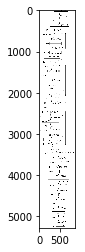

In [23]:
####################################################################################
#################### 설계한 모델을 확인하세요 ############################################
import matplotlib.image as mpimg
print (practice_model.summary())
plot_model(practice_model,'my_custom_model.png', show_layer_names=False, show_shapes=True)
model_img=mpimg.imread('my_custom_model.png')
plt.imshow(model_img)

#################### 설계한 모델을 확인하세요 ############################################
####################################################################################

In [24]:
practice_history = practice_model.fit(X_tr_input, Y_tr_onehot,validation_data=[X_te_input, Y_te_onehot], epochs=50, batch_size=128, verbose=1)
# list all data in history

Train on 10000 samples, validate on 1000 samples
Epoch 1/50
10000/10000 [==============================] - 17s 2ms/step - loss: 3.3539 - acc: 0.2010 - val_loss: 4.1199 - val_acc: 0.2560
Epoch 2/50
10000/10000 [==============================] - 7s 726us/step - loss: 2.2754 - acc: 0.2924 - val_loss: 2.1265 - val_acc: 0.2540
Epoch 3/50
10000/10000 [==============================] - 7s 698us/step - loss: 2.1486 - acc: 0.3402 - val_loss: 1.9296 - val_acc: 0.3280
Epoch 4/50
10000/10000 [==============================] - 8s 758us/step - loss: 1.9383 - acc: 0.3816 - val_loss: 1.7075 - val_acc: 0.3940
Epoch 5/50
10000/10000 [==============================] - 7s 718us/step - loss: 2.2606 - acc: 0.3638 - val_loss: 3.0651 - val_acc: 0.3860
Epoch 6/50
10000/10000 [==============================] - 7s 694us/step - loss: 1.8007 - acc: 0.4300 - val_loss: 1.4302 - val_acc: 0.4840
Epoch 7/50
10000/10000 [==============================] - 7s 725us/step - loss: 1.6584 - acc: 0.4584 - val_loss: 1.8147 - va

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


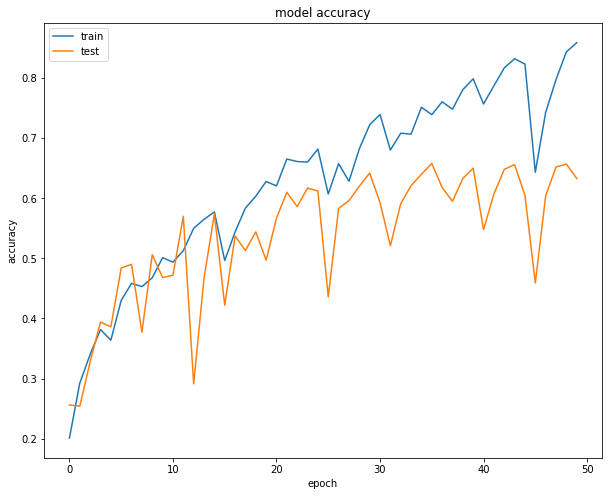

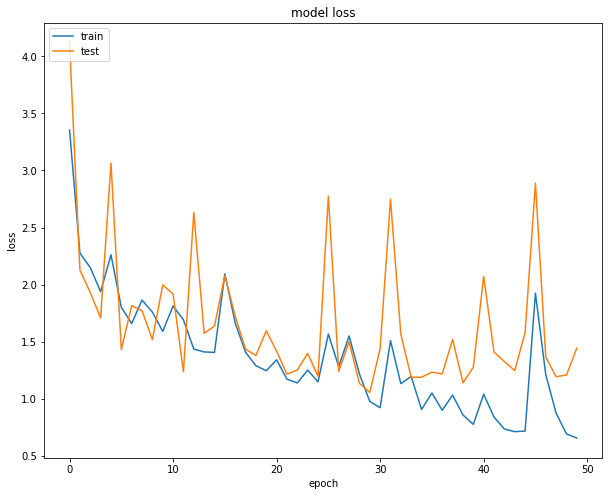

In [25]:
print(history.history.keys())

plt.figure(figsize=[10,8])
plt.plot(practice_history.history['acc'])
plt.plot(practice_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(figsize=[10,8])
plt.plot(practice_history.history['loss'])
plt.plot(practice_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### 최종 Accuracy는 최소 0.6을 넘겨야 함

In [26]:
print ('best accuracy : ', max(practice_history.history['val_acc']))

best accuracy :  0.6580000019073486
